
## This notebook shows how to use Grizli to

retrieve and pre-process raw CLEAR G102/F105W and 3D-HST G141/F140W observations for a single CLEAR pointing (GS1).

These series of notebooks draw heavily from Gabe Brammer's existing grizli notebooks, which are available at https://github.com/gbrammer/grizli/tree/master/examples, but with examples specific for the CLEAR survey.

In [1]:
import grizli
try: 
    from mastquery import query, overlaps
    use_mquery = True
except: 
    from hsaquery import query, overlaps
    use_mquery = False

import os
import numpy as np
from IPython.display import Image
from grizli.pipeline import auto_script
import glob
from glob import glob
import astropy
from grizli.prep import process_direct_grism_visit
from astropy.io import fits


## The paths defined below need to be changed to your own directories.
### the PATH_TO_CATS directory should include the following:
        ###     reference mosaic image (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sci.fits)
        ###     segmentation map       (e.g., Goods_S_plus_seg.fits)
        ###     source catalog         (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat)
        ###     radec_catalog          (e.g., goodsS_radec.cat)
        ###     3DHST Eazy Catalogs    (e.g., goodss_3dhst.v4.1.cats/*)
### these are all available on the team archive: https://archive.stsci.edu/pub/clear_team/INCOMING/for_hackday/
### the HOME_PATH directory is where the raw data, reduced data, and grizli outputs will be stored


In [2]:
field           = 'GS1'
ref_filter      = 'F105W'

HOME_PATH       = '/Users/rsimons/Desktop/clear/for_hackday/%s'%field
PATH_TO_CATS    = '/Users/rsimons/Desktop/clear/Catalogs'

# Create [HOME_PATH] and [HOME_PATH]/query_results directories if they do not already exist
if not os.path.isdir(HOME_PATH): os.system('mkdir %s'%HOME_PATH)
if not os.path.isdir(HOME_PATH + '/query_results'): os.system('mkdir %s/query_results'%HOME_PATH)

# Move to the [HOME_PATH] directory
os.chdir(HOME_PATH)


## Run an initial query for all raw G102 data in the ESA archive with a target name that includes the phrase 'GS1' and a proposal ID of 14227 (i.e., GS1 pointing of CLEAR). 

In [3]:
parent = query.run_query(box = None, proposal_id = [14227], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters = ['G102'], target_name = 'GS1')

## Next, find all G102 and G141 observations that overlap with the pointings found in the initial query.

Iter #1, N_Patch = 1


 0 j0333m2742 53.24696550387 -27.69263492857333
 target_name 
-------------
GOODS-SOUTH-1
          GS1 

filter j0333m2742          WFC3/IR G102    6   27670.5
filter j0333m2742          WFC3/IR G141    1    4711.7


0

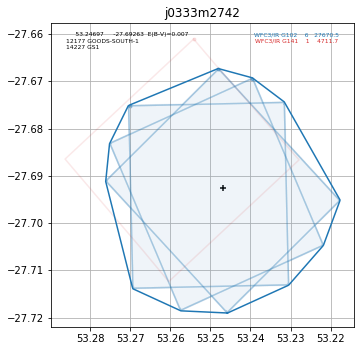

In [36]:
# Find all G102 and G141 observations overlapping the parent query in the archive
tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['G102', 'G141'], 
                              instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC'], close=False)

footprint_fits_file = glob('*footprint.fits')[0]
jtargname = footprint_fits_file.strip('_footprint.fits')


# A list of the target names
fp_fits = fits.open(footprint_fits_file)
overlapping_target_names = set(fp_fits[1].data['target'])


# Move the figure files to $HOME_PATH/query_results/ so that they are not overwritten
os.system('cp %s/%s_footprint.fits %s/query_results/%s_footprint_%s.fits'%(HOME_PATH, jtargname, HOME_PATH, jtargname, 'all_G102_G141'))
os.system('cp %s/%s_footprint.npy %s/query_results/%s_footprint_%s.npy'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))
os.system('cp %s/%s_footprint.pdf %s/query_results/%s_footprint_%s.pdf'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))
os.system('cp %s/%s_info.dat %s/query_results/%s_info_%s.dat'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))


## We now have a list of G102 and G141 observations in the MAST archive that overlap with the GS1 pointing of CLEAR. 

### For each, retrieve all associated RAW grism G102/G141 and direct imaging F098M/F105W/F125W/F140W data from MAST.

**For GS1, the retrieval step takes about 30 minutes to run and requires 1.9 GB of space.


In [ ]:
for t, targ_name in enumerate(overlapping_target_names):
    if use_mquery:
        extra = {'target_name':targ_name}
    else:
        extra = query.DEFAULT_EXTRA.copy()
        extra += ["TARGET.TARGET_NAME LIKE '%s'"%targ_name]
    
    # search the ESA archive for overlapping grism and direct imaging observations with that target name
    tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                                  filters=['G102', 'G141', 'F098M', 'F105W', 'F125W', 'F140W'], 
                                  instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC'], 
                                  extra=extra, close=False)
    if False:
        #retrieve the raw data products
        auto_script.fetch_files(field_root=jtargname, HOME_PATH=HOME_PATH, remove_bad=True, 
                                reprocess_parallel=True, s3_sync = False)

    # Move the figure files to $HOME_PATH/query_results/ so that they are not overwritten
    os.system('mv %s/%s_footprint.fits %s/query_results/%s_footprint_%s.fits'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
    os.system('mv %s/%s_footprint.npy %s/query_results/%s_footprint_%s.npy'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
    os.system('mv %s/%s_footprint.pdf %s/query_results/%s_footprint_%s.pdf'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
    os.system('mv %s/%s_info.dat %s/query_results/%s_info_%s.dat'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))

    os.chdir(HOME_PATH)

### New directories are created from auto_script.fetch_files:
        [HOME_PATH]/j0333m2742
        [HOME_PATH]/j0333m2742/RAW
        [HOME_PATH]/j0333m2742/Prep
        [HOME_PATH]/j0333m2742/Extractions
        [HOME_PATH]/j0333m2742/Persistance
         
        
RAW/ is where the downloaded raw and pre-processed data are stored.

Prep/ is the general working directory for processing and analyses.





In [46]:
PATH_TO_RAW     = glob(HOME_PATH + '/*/RAW')[0]
PATH_TO_PREP    = glob(HOME_PATH + '/*/PREP')[0]

# Move to the Prep directory
os.chdir(PATH_TO_PREP)

### Next, Grizli will parse the header files of the downloaded flt files in RAW/ and sort them into "visits". Each visit represents a specific pointing + orient + filter and contains the list of its associated exposure files.

In [47]:
# Find all pre-processed flt files in the RAW directory
files = glob('%s/*flt.fits'%PATH_TO_RAW)
# Generate a table from the headers of the flt fits files
info = grizli.utils.get_flt_info(files)

# The table includes relevant exposure details: e.g., filter, instrument, targetname, PA, RA, DEC
# print the first three rows of the table
info[0:3]



FILE,FILTER,INSTRUME,DETECTOR,TARGNAME,DATE-OBS,TIME-OBS,EXPSTART,EXPTIME,PA_V3,RA_TARG,DEC_TARG,POSTARG1,POSTARG2
str18,str5,str4,str2,str13,str10,str8,float64,float64,float64,float64,float64,float64,float64
icxt12quq_flt.fits,F105W,WFC3,IR,GS1,2016-01-28,06:09:43,57415.25674951,302.938477,269.001587,53.25006791667,-27.68959166667,-14.601,-5.077
icxt09ezq_flt.fits,F105W,WFC3,IR,GS1,2015-12-20,13:18:14,57376.55432926,302.938477,226.563293,53.25006791667,-27.68959166667,-14.601,-5.077
ibhj01ivq_flt.fits,F140W,WFC3,IR,GOODS-SOUTH-1,2011-11-27,18:04:31,55892.75314558,202.933945,177.000107,53.257475,-27.68902222222,1.355,0.424


In [44]:
# Parse the table and group exposures into associated "visits"
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)

# an F140W imaging visit
print ('\n\n visits[0]\n\t product: ', visits[0]['product'], '\n\t files: ', visits[0]['files'])

# a g141 grism visit
print ('\n\n visits[1]\n\t product: ', visits[1]['product'], '\n\t files: ', visits[1]['files'])



goodss-01-bhj-01-177.0-F140W 4
goodss-01-bhj-01-177.0-G141 4
GS1-cxt-09-227.0-F105W 2
GS1-cxt-10-227.0-F105W 2
GS1-cxt-07-249.0-F105W 2
GS1-cxt-08-249.0-F105W 2
GS1-cxt-11-269.0-F105W 2
GS1-cxt-12-269.0-F105W 2
GS1-cxt-09-227.0-G102 4
GS1-cxt-10-227.0-G102 4
GS1-cxt-07-249.0-G102 4
GS1-cxt-08-249.0-G102 4
GS1-cxt-11-269.0-G102 4
GS1-cxt-12-269.0-G102 4


 visits[0]
	 product:  goodss-01-bhj-01-177.0-f140w 
	 files:  ['ibhj01ioq_flt.fits', 'ibhj01ivq_flt.fits', 'ibhj01j2q_flt.fits', 'ibhj01j9q_flt.fits']


 visits[1]
	 product:  goodss-01-bhj-01-177.0-g141 
	 files:  ['ibhj01iqq_flt.fits', 'ibhj01ixq_flt.fits', 'ibhj01j4q_flt.fits', 'ibhj01jbq_flt.fits']


<h1><center>Pre-processing</center></h1>

We are now ready to pre-process the downloaded RAW data.


### process_direct_grism_visit performs all of the necessary preprocessing:

- Copying the flt files from Raw/ to Prep/
- Astrometric registration/correction
- Grism Sky background subtraction and flat-fielding
- Extract visit-level catalogs and segmentation images from the direct imaging



### The final products are:

1. Aligned, background-subtracted FLTS

2. Drizzled mosaics of direct and grism images

In [33]:
if True:
    if 'N' in field.upper(): radec_catalog = PATH_TO_CATS + '/goodsN_radec.cat'
    if 'S' in field.upper(): radec_catalog = PATH_TO_CATS + '/goodsS_radec.cat'                    

    product_names = np.array([visit['product'] for visit in visits])
    filter_names = np.array([visit['product'].split('-')[-1] for visit in visits])
    basenames = np.array([visit['product'].split('.')[0]+'.0' for visit in visits])

    # First process the G102/F105W visits, then G141/F140W
    for ref_grism, ref_filter in [('G102', 'F105W'), ('G141', 'F140W')]:
        print ('Processing %s + %s visits'%(ref_grism, ref_filter))
        for v, visit in enumerate(visits):
            product = product_names[v]
            basename = basenames[v]
            filt1 = filter_names[v]
            field_in_contest = basename.split('-')[0]
            if (ref_filter.lower() == filt1.lower()):
                #Found a direct image, now search for grism counterpart
                grism_index= np.where((basenames == basename) & (filter_names == ref_grism.lower()))[0][0]
                if False:
                    # run the pre-process script
                    status = process_direct_grism_visit(direct = visit,
                                                        grism = visits[grism_index],
                                                        radec = radec_catalog, 
                                                        align_mag_limits = [14, 23])



Processing G102 + F105W visits
Processing G141 + F140W visits


## Astrometric correction

# ext xshift yshift rot scale rms N
# gs1-cxt-09-227.0-f105w
    0        0.3755       -2.5081       -0.0392       0.99995         0.153   25


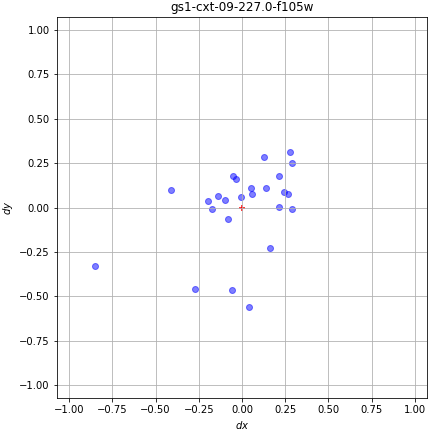

In [34]:
os.chdir(PATH_TO_PREP)
!cat gs1-cxt-09-227.0-f105w_wcs.log
Image(filename = PATH_TO_PREP + '/gs1-cxt-09-227.0-f105w_wcs.png', width = 600, height = 600)

## Grism sky subtraction

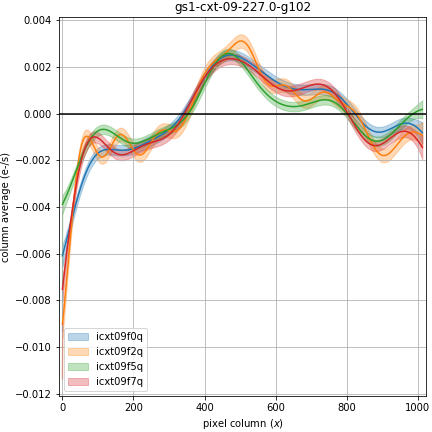

In [35]:
os.chdir(PATH_TO_PREP)
Image(filename = PATH_TO_PREP + '/gs1-cxt-09-227.0-g102_column.png', width = 600, height = 600)